# NE204 Lab 1: Pulse Processing 
__Dates: 08/2022 to 10/2022.__

__Group: Megan Schiferl, Chris Lamb, Curtis Berger, Jisu Park__

__Contents:__

1. Imports & Directory
2. Timestamp Information
3. Saving Raw Data to Array
4. Removing Saturation
5. Background Subtraction
6. Looking at Pile-Up and Rise Time
7. Applying a Savinsky-Golay Filter
8. Finding Start of Rise (i) and Rise Time (k)
    Versions 1 - 4
9. Finding Tau
10. Defining the Trapezoidal Filter

__In the works:__

11. Applying the trapezoidal filter to pulses and saving trapezoids to a file
12. Finding the average height of each trapezoid
13. Creating an energy spectrum (histogram of trapezoid heights)
14. Testing the effects of changing __gap time__ while keeping constant peaking time
15. Testing the effects of changing __peaking time__ with constant gap time

# Section 1: Imports & Directory

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import time
import pandas as pd
from scipy import signal
from scipy.signal import savgol_filter
from scipy.optimize import curve_fit
import os
from tqdm import tqdm
import matplotlib.style as mplstyle

In [2]:
#check current working directory
retval = os.getcwd()
print ("Current working directory %s" %retval)

# change directory
os.chdir(r'C:\Users\megas\Documents\Cal\NEFall2022\NE204')

Current working directory C:\Users\megas\Documents\GitHub_NE-204\Lab-1


In [3]:
#check current working directory
retval = os.getcwd()
print ("Current working directory %s" %retval)

Current working directory C:\Users\megas\Documents\Cal\NEFall2022\NE204


In [4]:
#Input the data file and find the keys
f = h5py.File(r"C:\Users\megas\Documents\Cal\NEFall2022\Detectors204\lab1\923Data\Cs137-1min.h5", 'r')

#print the keys for the file path
print(f.keys())
print(f['raw_data'])

<KeysViewHDF5 ['event_data', 'raw_data']>
<HDF5 dataset "raw_data": shape (3162, 62500), type "<u2">


# Section 2: Timestamp Information
 - Upon checking the timestamp information in event data, it is clear that the last second of data is repeated.

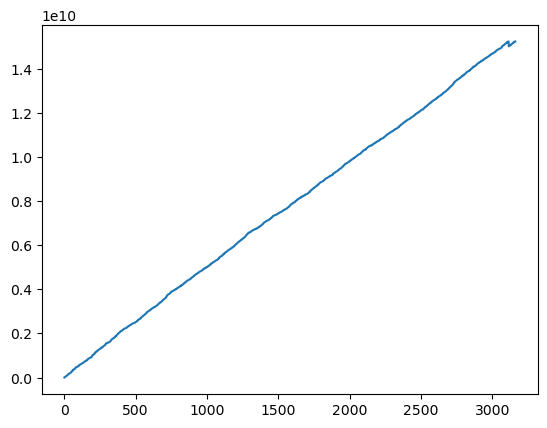

In [5]:
#The second of data is repeated - remove from consideration
plt.plot(f['event_data']['timestamp'])

# Section 3: Saving the useful raw data to an array 
 - Saved raw data to an array for easy access
 - Removed the last second of data
 - Plotted the raw pulses to check pulse shape: expected to find ~1000 pre-trigger delay time, then a sharp rise, and a long exponential decay


In [6]:
pulses = np.array(f['raw_data'])
print(len(pulses))
pulses = pulses[:-1]
print(len(pulses))

3162
3161


<class 'numpy.ndarray'> (3161, 62500)
[7912 7909 7900 ... 7909 7907 7910]
62500
8041
8041


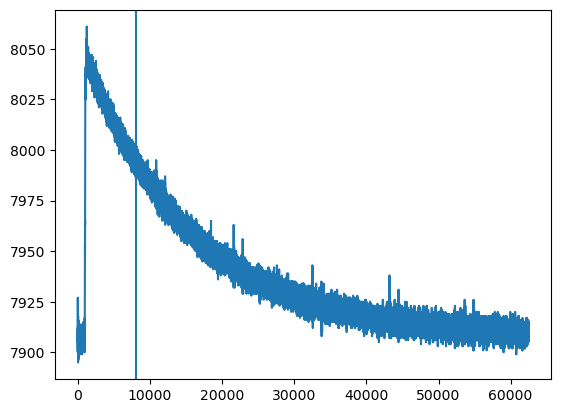

In [7]:
print(type(pulses), pulses.shape)
print(pulses[0])
print(pulses[0].size)
print(pulses[0,1200])
print(pulses[0][1200])
plt.plot(pulses[0])
plt.axvline(pulses[0][1200])

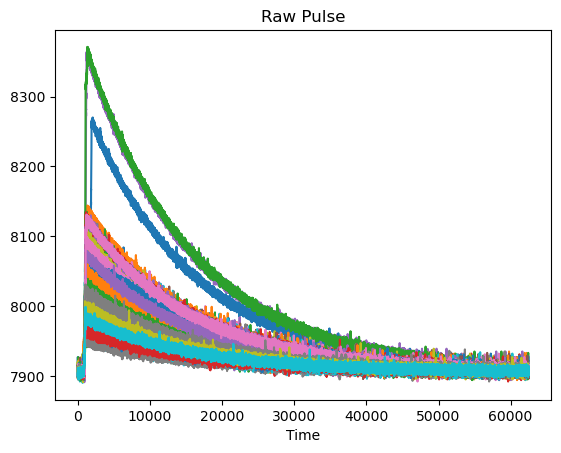

In [8]:
#Plot the raw data
plt.figure()

for i in range(0, 100):
    plt.plot(np.arange(pulses[i].size), pulses[i])
    plt.xlabel('Time')
    plt.title('Raw Pulse')

# Section 4: Removing Saturated Signals
 - Identified the value of saturation
 - Created a new array which holds only the non-saturated pulses

In [9]:
#remove saturated signals
sat = np.amax(np.amax(pulses))
print("The saturation value is", sat)

nonsat_pulses = []
for i in range(len(pulses)):
    max_y = np.amax(pulses[i])
    if (max_y != sat):
        nonsat_pulses.append(pulses[i])

nonsat_pulses = np.array(nonsat_pulses)
print(nonsat_pulses.shape)   
print(pulses.shape)

The saturation value is 16383
(3134, 62500)
(3161, 62500)


# Section 5: Background Subtract
 - First looking at the noise and finding some noise heights above the mean
 - Find the mean of the noise floor
 - Subtract the noise floor from the non-saturated pulses

<class 'numpy.ndarray'>
(3134, 62500)


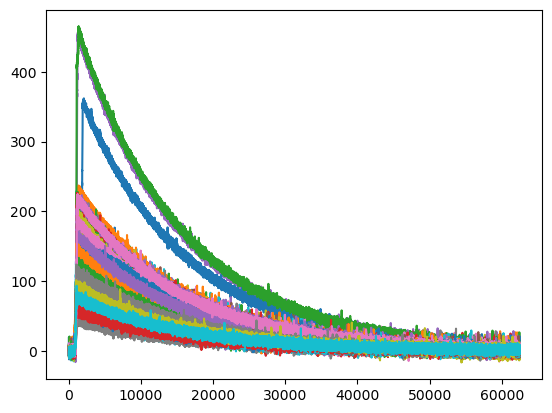

In [10]:
#Background subtraction for the raw data
n = len(nonsat_pulses)
print(type(nonsat_pulses))
pulses_sub = []
for i in range(n):
    bkg = np.mean(nonsat_pulses[i][0:500])
    pulses_sub.append(nonsat_pulses[i] - bkg)
    
pulses_sub = np.array(pulses_sub)
print(pulses_sub.shape)
for i in range(100):
    plt.plot(pulses_sub[i])

The average noise height is: 9.1475
The minimum noise height is: 6.5 The maximum noise height is: 21.5


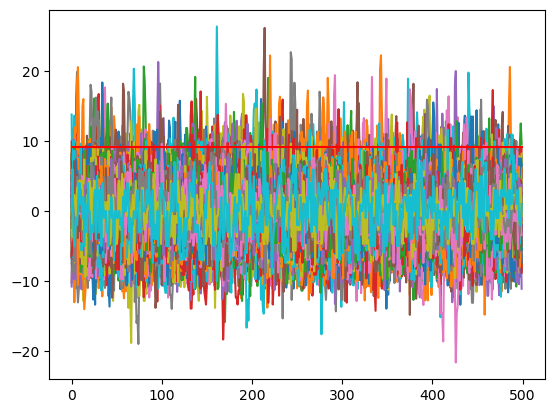

In [11]:
#Plotting the pre-trigger area for a look at the background
#getting the average noise height
noiseh = []
noisemin_ar = []
noisemax_ar = []
plt.figure()
for i in range(1000):
    plt.plot(pulses_sub[i][0:500])
    noisemin = np.amin(pulses_sub[i][0:500])
    noisemin_ar.append(noisemin)
    noisemax = np.amax(pulses_sub[i][0:500])
    noisemax_ar.append(noisemax)
    half = (noisemax-noisemin)/2
    noiseh.append(half)
avg_noiseh = np.mean(noiseh)
plt.hlines(np.amin(avg_noiseh), 0, 500, colors="r", label = 'Average Noise Height: {}'.format(np.amin(avg_noiseh)))

print("The average noise height is:", avg_noiseh)
print("The minimum noise height is:", np.amin(noiseh), "The maximum noise height is:", np.amax(noiseh))

# Section 6: Looking at Pile-Up and Rise Times
 - Basically just zooming in on the rise area

<class 'numpy.ndarray'> (3134, 62500)


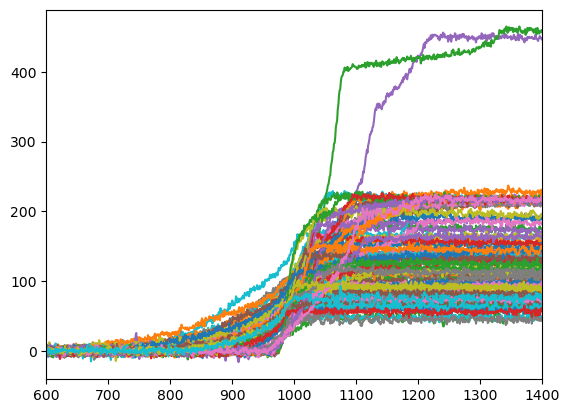

In [12]:
#Plotting the rise of a bunch of data to see possible pileup
for i in range (100):
    plt.plot(pulses_sub[i]) 
    plt.xlim(600,1400) #we expect the rise to be around the pre-trigger value 1000t
    
print(type(pulses_sub), pulses_sub.shape)

# Section 7: Applying a Savinsky-Golay Filter
 - Our trapezoidal filters don't work well without noise filtering, so savgov it is

(3134, 62500)


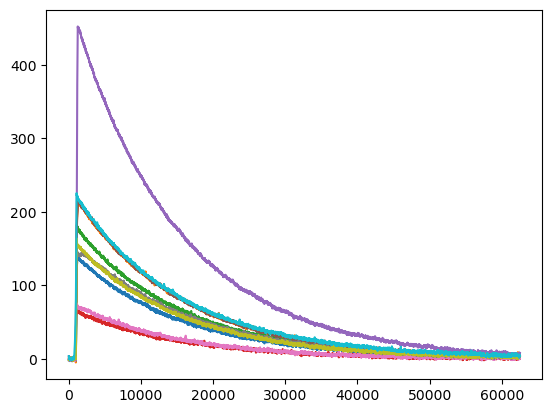

In [13]:
#filtering the signals
fs = savgol_filter(pulses_sub, 51, 2)
print(fs.shape)
for i in range(10):
    plt.plot(fs[i])

# Section 8: Finding Start of Rise (i) and Rise Time (k)
   > Version 1: Trying to find the upper and lower bounds of the rise time using the max value of the signal and the median of a difference array, respectively. This version does an okay job at all of these things. A histogram is shown for the given maximum peak value (via np.argmax) and it's clear that depending on the signal, this does a good, decent, and horrible job of finding the actual end of the rise. 
   
   > Version 2: Finds the cumulative standard deviation of the pulse, calculates the gradient of the cumulative standard deviations, and determines the start and end of the rise via the max and min of the gradient of the cumulative standard deviations, respectively. As seen in the graph that shows the pulse vs the gradient of the std deviations, this method chooses an i that is slightly too high. 
   
   > Version 3: I was trying to make a version of this where you find the local minima, and then there should be a larger distance between local minima at the rise than anywhere else in the pulse, but it ends up devolving to version 1 fairly quickly.
   
   > Version 4: This one seems to be a winner - go Chris! Here we take the gradient of the pulse anywhere that the signal is 8 * sigma greater than the mean of the noise floor, and everywhere else, we set to zero. If there are any noise bumps before the actual signal rise, the gradient will become negative within some window of time. So we check for that occurance, and if it doesn't happen, we have identified the rise. Since we have identified the index at 8 sigma above the mean, we need to shift back to the left a few channels, and we're there!
   
__Moving On: using version 4 as the i value, and k will be set approximately at 350 for all signals. This will be optimized later.__

In [14]:
#Version 1 of rise time determination
def get_k_v1(signal):
    end_index = np.argmax(signal)
    diff_list = []
    N = 0
    diff_array = np.array([signal[end_index] - signal[end_index - n] for n in range(end_index)])
    med = np.median(diff_array)
    for n in range(len(diff_array)):
        if diff_array[n]>0.998*med:
            N = n
            break
    return N

k_array = []
for i in range(len(fs)):
    k_array.append(get_k_v1(fs[i]))

kavg = np.mean(k_array)
k = round(kavg, 0)
print(k)

351.0


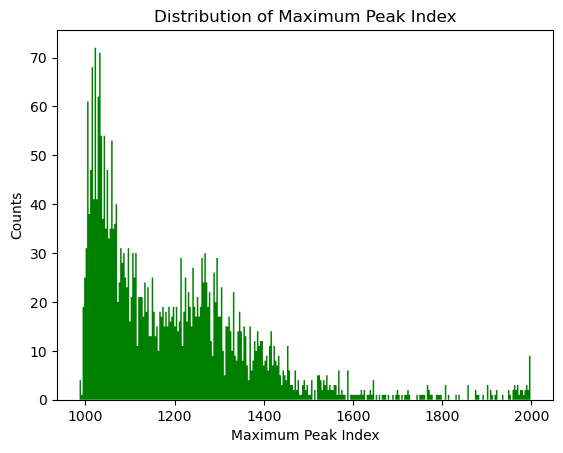

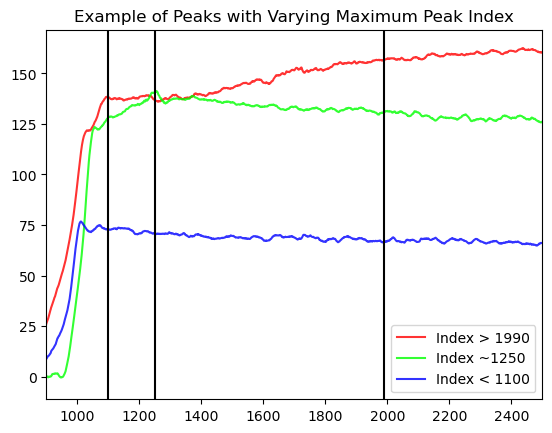

In [15]:
#find the index of the max value for each fitted signal
imax = []
for i in range(len(fs)):
    if np.argmax(fs[i][0:2000]) != 1999:
        imax.append(np.argmax(fs[i][0:2000])) # only looking at the first 2000 to avoid late pileup signals

#Plot this out as a histogram to see what the results look like
imax_hist, imax_bins = np.histogram(imax, bins = 300)
plt.figure()
plt.title("Distribution of Maximum Peak Index")
plt.xlabel("Maximum Peak Index")
plt.ylabel("Counts")
plt.hist(imax_bins[:-1], imax_bins, weights = imax_hist, histtype='stepfilled', color = 'g')

#Multiple unexpected values, both high, and around 1250, so let's plot the signals to see what's going on
high_imax = []
plt.figure()
plt.title("Example of Peaks with Varying Maximum Peak Index")
plt.xlim(900, 2500)
for i in range(len(imax)):
    if imax[i] > 1990:
        high_imax.append(fs[i])        
high_imax = np.array(high_imax)
for i in range(1):
    plt.plot(high_imax[i], label = "Index > 1990", c = (1,0,0,0.2*(5-(i+1))))
    
mid_imax = []
for i in range(len(imax)):
    if 1200 <= imax[i] <= 1300:
        mid_imax.append(fs[i])
mid_imax = np.array(mid_imax)
for i in range(1):
    plt.plot(mid_imax[i], label = "Index ~1250", c = (0,1,0,0.2*(5-(i+1))))
    
low_imax = []
for i in range(len(imax)):
    if imax[i] < 1100:
        low_imax.append(fs[i])
low_imax = np.array(low_imax)
for i in range(1):
    plt.plot(low_imax[i], label = "Index < 1100", c = (0,0,1,0.2*(5-(i+1))))
plt.legend()

plt.axvline(1100, c = "k")
plt.axvline(1250, c='k')
plt.axvline(1990, c='k')

These are rise start values [ 993  991 1021  931 1046  998  932  946  998  925]
Shape of signals array (10, 62500)
These are the k values [ 262  721   89  431  511  458   80 1465   77  141]


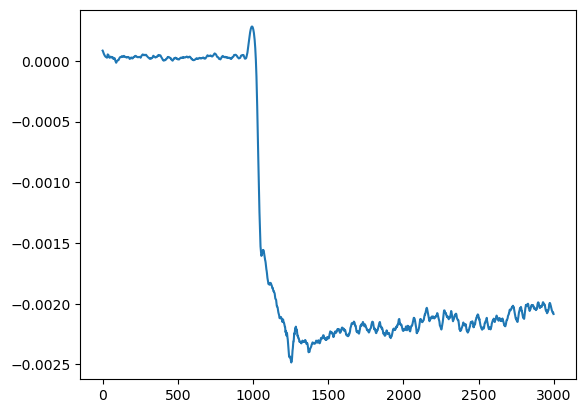

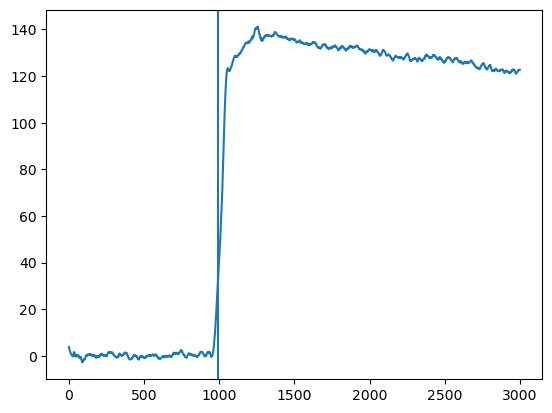

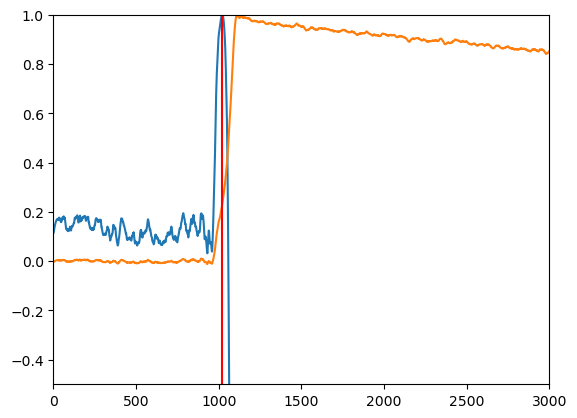

In [16]:
#Version 2 of rise time determination
def get_k_v2(vs,number_rises):
    # vs is a array of signals
    # number_rises is how many signals to process
    k_array = np.ones(number_rises)
    cRMS = [np.array([np.std(vs[i,n:-1]) for n in range(3000)]) for i in range(number_rises)]    
    Gradients = [np.gradient(cRMS[i]) for i in range(number_rises)]
    ks = np.array([np.argmax(Gradients[i]) - np.argmin(Gradients[i]) for i in range(number_rises)])
    i = np.array([np.argmax(Gradients[i]) for i in range(number_rises)]) 
    r = np.array([np.argmin(Gradients[i]) for i in range(number_rises)]) 
    ks = r - i
    return cRMS, Gradients, ks, i ,r

crms, grad, k, i, r = get_k_v2(fs[:10,:], 10)
print("These are rise start values", i)
print("Shape of signals array", f['raw_data'][:10,:].shape)
print("These are the k values", k)

plt.figure()
for i in range(1):
    plt.plot(grad[i])
    
plt.figure()
for i in range(1):
    plt.plot(fs[i,:3000])
plt.axvline(np.argmax(grad[1]))

plt.figure()
#As you can see in this plot, the max of the gradient is not exactly the start of the signal.
plt.plot(grad[2]/max(grad[2]))
plt.plot(fs[2]/max(fs[2]))
plt.xlim(0,3000)
plt.ylim(-0.5,1)
plt.axvline(np.argmax(grad[2]), c='r')
plt.show()

[   24    29    31 ... 62467 62470 62473]
12299


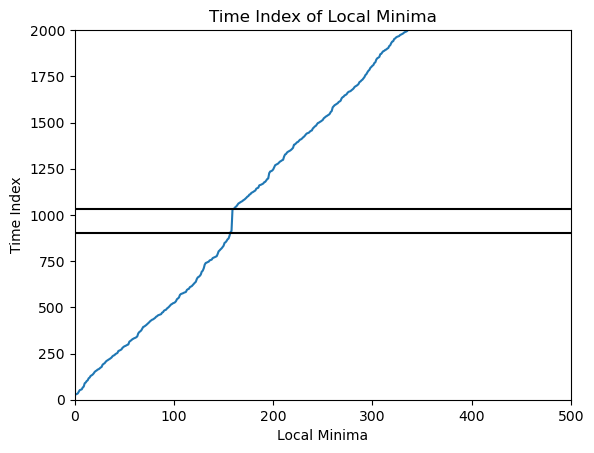

In [18]:
#Version 3 for finding i and k
from scipy.signal import argrelmin
localmins = argrelmin(fs[728],order=1)
lm = localmins[0]
print(lm)
print(len(lm))

#Plot the number of local minima vs their time index
plt.figure()
plt.ylim(0,2000)
plt.xlim(0,500)
plt.ylabel("Time Index")
plt.xlabel("Local Minima")
plt.title("Time Index of Local Minima")
plt.plot(localmins[0])
plt.axhline(1030, c='k')
plt.axhline(900, c='k')

In [30]:
#Version 3 cont. 
mindif = []
for i in tqdm(range(500)):
    dif = fs[728][lm[i+1]] - fs[728][lm[i]]
    mindif.append(dif)

mindif = np.array(mindif)
ms = np.amin(mindif)
print(ms)

100%|██████████| 500/500 [00:00<00:00, 260710.09it/s]

-2.8842329384580836


In [19]:
#Version 4: Chris's version
def determine_rise(signal, sigma=8, window=20, offset=15):
    noise_samp = signal[:500]
    mean, std = np.mean(noise_samp), np.std(noise_samp)
    
    grad = np.gradient(np.where(signal > mean+sigma*std, signal, 0))
    
    grad_pos, grad_neg = np.argwhere(grad>2), np.argwhere(grad<-2)
    
    rise_start = 0
    for gp in grad_pos:
        close = False
        for gn in grad_neg:
            if np.abs(gp-gn) < window:
                close = True
        if not close:
            rise_start = gp
            break
    
    return int(rise_start-offset)

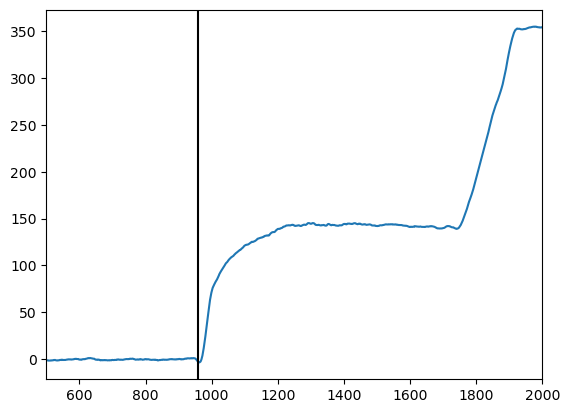

In [26]:
#Testing Version 4 with real signals
n = 10
i_v4 = determine_rise(fs[n])
plt.figure()
plt.xlim(500,2000)
plt.plot(fs[n])
plt.axvline(i_v4,c='k')

# Section 9: Finding Tau
 - Defining an exponential function
 - Fitting each pulse to the exp function
 - Finding the decay constant (tau)

In [ ]:
#defining an exponential function
def exp_func(x, a, b, c):
    #returns a times e^(-b times a) + c
    return a * np.exp(-b * x) + c

In [ ]:
#fit an exponential curve to the decay of each signal to find tau
tau = []
for i in (range(100)):
    #setting the ranges for exp fitting and x axis parameters
    endfit = 20000
    s = imax[i] #index of max for pulse i
    x = np.arange(0, endfit) #array of values from max index upward for some number of indices, len(x)=endfit
    
    #using exp_func over the values in x
    #fits an exp to the ith pulse from index of max to endfit+index of max
    try:
        popt, pcov = curve_fit(exp_func, x, fs[i][s:endfit+s])
        tau.append(1/popt[1])
    except:
        tau.append(0)

tau = list(filter(lambda a: a != 0, tau))
tau = np.array(tau)
tau_avg = np.mean(tau)
print(tau_avg)
    
#plot fitted exponential against bkg sub raw data
#plt.plot(range(s,s+len(exp_func(x, *popt))),exp_func(x, *popt))
#plt.scatter(np.arange(0,len(fs[i])),fs[i], s=1, color='orange')

# Section 10: Defining the Trapezoidal Filter
 - Define dkl
 - Define the trapezoid with pole-zero correction

In [ ]:
#Define the trapezoidal filter, i is the start of the rise
def dkl(signal, i, k, l, w=0):
    if w == 0:
        w = len(signal)//4
    vj = signal[i:i+w]
    vjk = signal[i-k:i+w-k]
    vjl = signal[i-l:i+w-l]
    vjkl = signal[i-k-l:i+w-k-l]
    return vj - vjk - vjl + vjkl

#This is way too slow - save to a list and find the previous value 
#def sn(signal, t, tau, i, k, l, w):
#     if t == 0:
#         return 0
#     else:
#         return sn(signal, t-1, tau, i, k, l, w)*(1+1/tau) + dkl(signal, i, k, l, w)[t]
    
# def s(signal, i, tau, k, l, w):
#     return np.array([sn(signal, j, tau, i, k, l, w) for j in range(w)])

In [ ]:
#Define m(gap time) and l (l-k is the length of the trapezoid top) and w
m = 200 #arbitrarily assigned
l = k + m  
w = 2.5*k + m

s = []
for i in range(5)
    s = s(fs[i], )
